# Simpler Markov Chain Monte Carlo
Bayesian analysis has gained more popularity in recent years, especially in modern Machine Learning applications.  One of the greatest advantage of Bayesian Analysis is that it infers the underlying distribution (posterior) from observationns, and MCMC plays an important part in obtaining the posterior.

This practice is done by following: https://twiecki.io/blog/2015/11/10/mcmc-sampling/

## Obtain posterior
Below is the famous Bayes equation:
$P(\theta | x)=\frac{P(x|\theta)\cdot P(\theta)}{P(x)}$.  
$x$ in the above equation is the data, and $P(\theta)$ is our preliminary guess of the parameters of the underlying distribution.  $P(x|\theta)$ means how likely the data is following the guessed distribution and is called likelihood. Our goal is to find a refined $P(\theta)$ after seeing the data, which is called posterior $P(\theta | x)$.

### Calculation of posterior - closed form
In this simple case, we assume the likelihood is normally distributed.  If the prior also follows a Normal distribution, then the likelihood and prior form a [conjugate pair](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution), and the posterior will also be a Normal distribution.

In this fortunate situation, we can apply the conjugate transformation formula and calculate the posterior directly.  This way, we can avoid the heaache of calculating $P(x)=\int_{\theta} P(x, \theta)\ d\theta$

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm


%matplotlib inline
sns.set_style('white')
sns.set_context('talk')

np.random.seed(42)
data = np.random.randn(50)

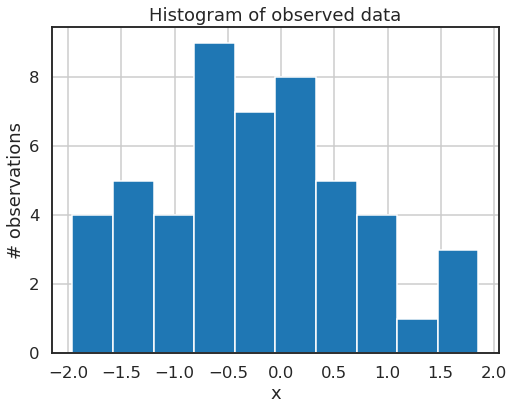

In [2]:
fig, ax = plt.subplots(figsize = (8, 6))
# sns.distplot(data, kde = False, ax = ax)
ax.hist(data)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations')
plt.grid()
plt.show()

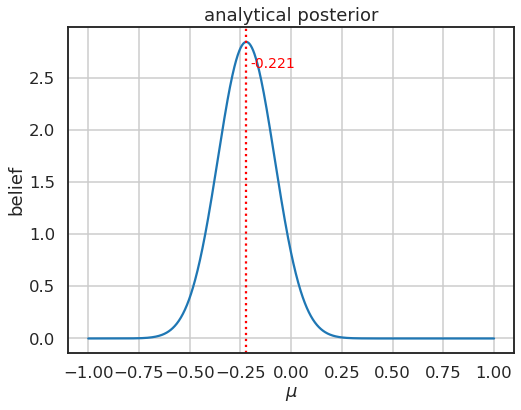

In [3]:
def posteriorCalc(data, mu_0, sigma_0):
    sigma = 1
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + sum(data) / sigma**2) \
                * (1 / sigma_0**2 + n / sigma**2)**-1
    sigma_post = (1 / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, sigma_post**0.5)
fig, ax = plt.subplots(figsize = (8, 6))
xs = np.linspace(-1, 1, 1000)
post_dist = posteriorCalc(data, 0, 1)
ax.plot(xs, post_dist.pdf(xs))
mode = post_dist.ppf(0.5)
ax.axvline(mode, color = 'r', linestyle = ':')
ax.annotate(f"{mode:.3f}", xy = (mode + abs(mode)*.1, 2.6), 
            color = 'r', size = 14)
_ = ax.set(xlabel = '$\mu$', 
           ylabel = 'belief', 
           title = 'analytical posterior')
plt.grid()


# ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')

### Calculation of posterior - MCMC
What if the likelihood and prior didn't form a conjugate pair?  In this case, we can resort to a sampling technique called Monte Carlo approximation.  This is done by choosing a random initial point in the parameter space and sampling from that initial distribution.

In the code below, we assume the standard deviation is known (fixed `proposal_width`) and the initial parameter `mu_init` is 0.5.  We then randomly sample a value from $Norm(\mu_{init},\ \text{proposal_width})$ called `mu_proposal`.  We then calculate likelihood and prior based `mu_curretn` and `mu_proposal` and obtain a new posterior.  If the proposed posterior is greater than the current posterior, `mu_proposal` has a better chance to be selected as the new `mu_current`.  By repeating this process many times, the resulted posterior of $\mu$ will be close to the analytical value.

In [4]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = posteriorCalc(data, mu_prior_mu, mu_prior_sd) \
                            .pdf(x)
    ax3.plot(x, posterior_analytical)
    posterior_current = posteriorCalc(data, mu_prior_mu, mu_prior_sd) \
                        .pdf(mu_current)
    posterior_proposal = posteriorCalc(data, mu_prior_mu, mu_prior_sd) \
                            .pdf(mu_proposal)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

array([ 0.5       ,  0.5       ,  0.30745886, -0.03100214, -0.03100214,
       -0.03100214, -0.03100214])

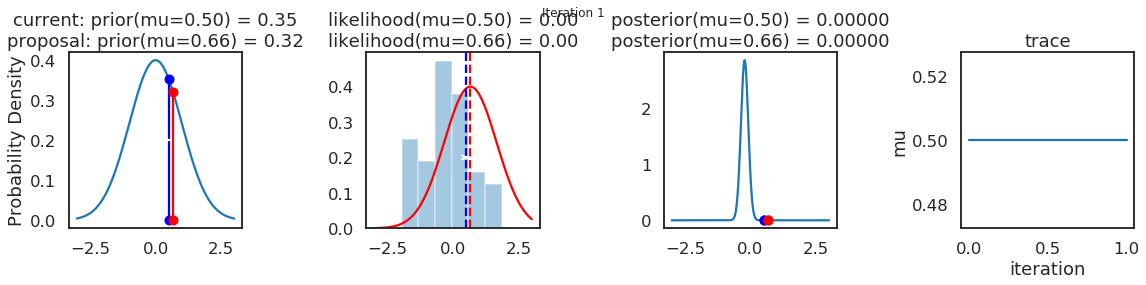

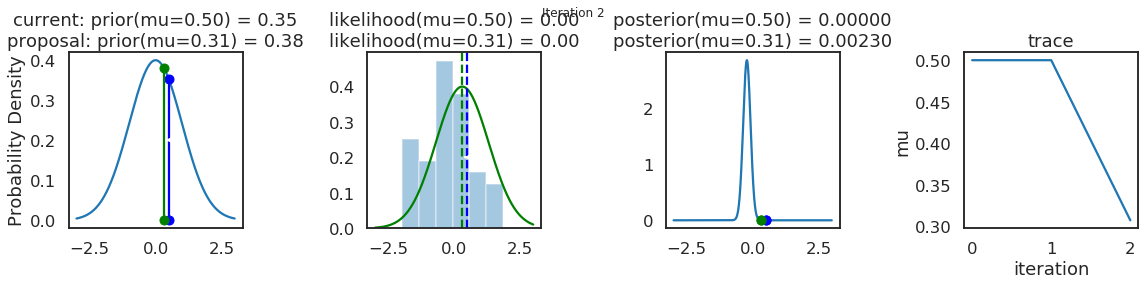

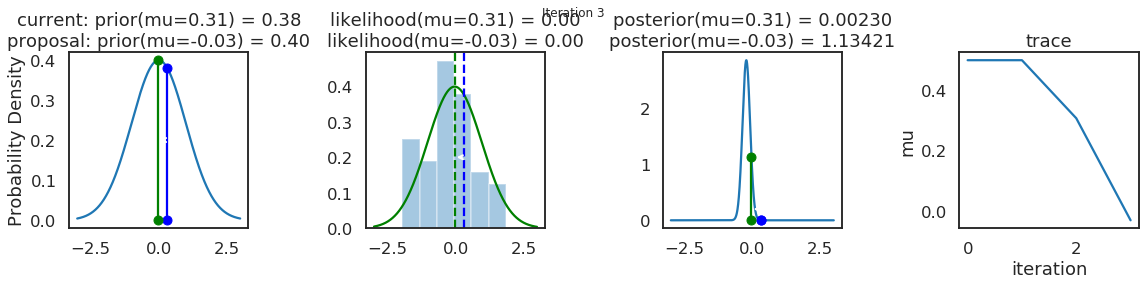

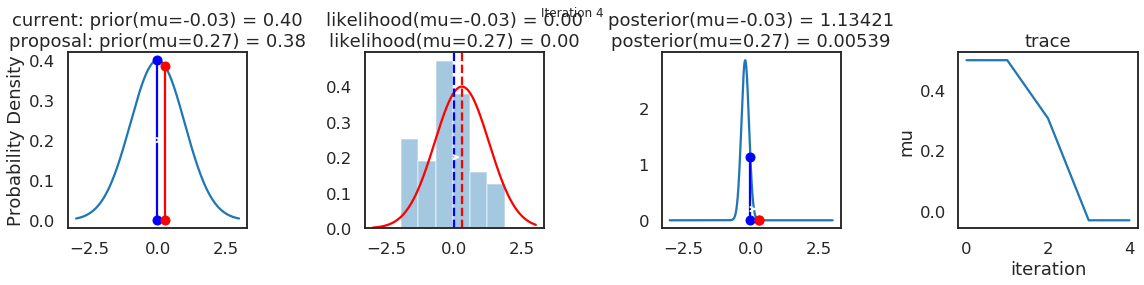

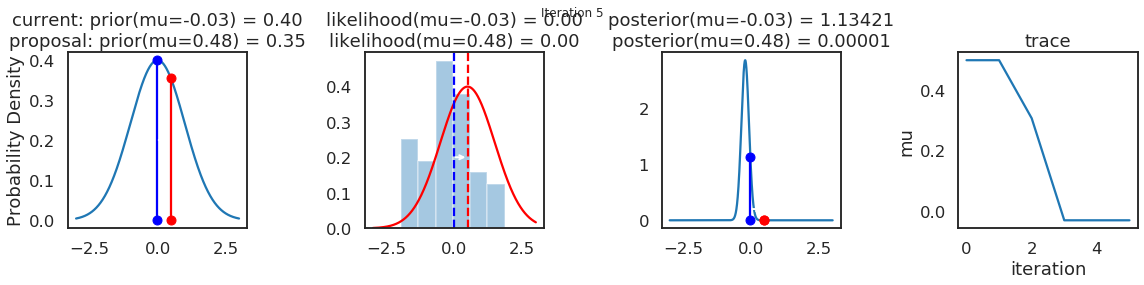

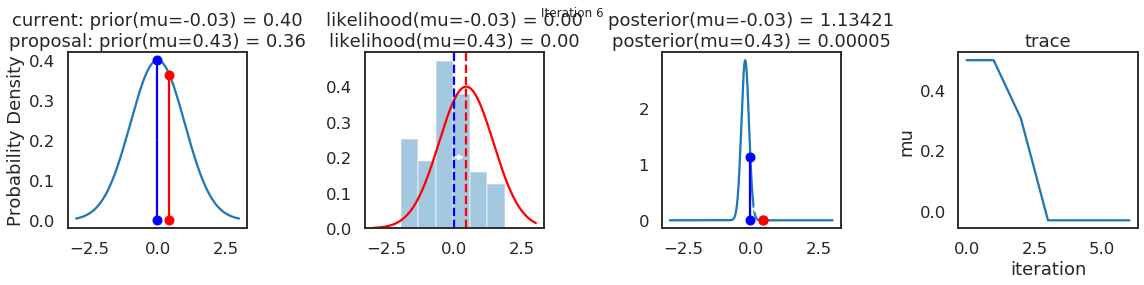

In [5]:
sampler(data, samples = 6, mu_init = 0.5, plot = True)

As can be seen in the following diagram, even though we started with a far-off $\mu_{init} = 1$, after many iterations the MCMC sampling stabilizes around the theoretical value.

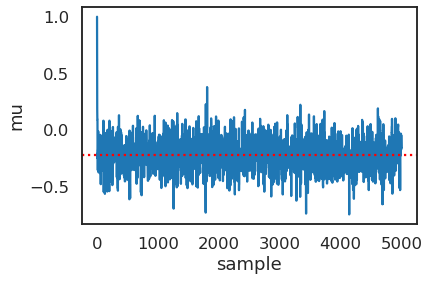

In [6]:
posterior = sampler(data, samples=5000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
ax.axhline(mode, color = 'r', linestyle = ':')
_ = ax.set(xlabel='sample', ylabel='mu')

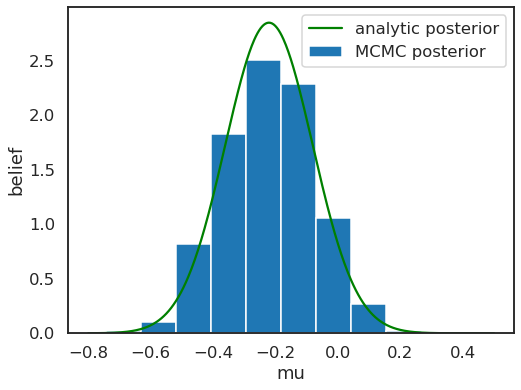

In [7]:
_, ax = plt.subplots(figsize = (8, 6))

# sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
ax.hist(posterior[500:], density = True, label = 'MCMC posterior')
x = np.linspace(-.8, .5, 500)
post = posteriorCalc(data, 0, 1)
ax.plot(x, post.pdf(x), 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend()
plt.show()